In [3]:
import os
import copy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic
# RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.molSize = 400,400
rdkit.__version__

'2023.09.1'

In [2]:
def rearrange_xyz(path, filename):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    # Open the original .xyz file and parse the lines with
    # O and H coordinates to lists
    with open(os.path.join(path, filename), 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # Open the .xyz file to write
        with open(os.path.join(path, filename), 'w') as fw:

            # Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # Write O coordinates
            for x in o_lines:
                fw.write(x)

            # Write H coordinates
            for y in h_lines:
                fw.write(y)

In [3]:
def create_mol_from_xyz(path):

    '''
    Take in the path of a .xyz file and use
    RDKit to create a mol object and SMILES string
    '''

    raw_mol = MolFromXYZFile(path)
    conn_mol = Chem.Mol(raw_mol)
    rdDetermineBonds.DetermineBonds(conn_mol)
    mol = copy.deepcopy(conn_mol)
    mol = Chem.RemoveAllHs(mol)

    Chem.RemoveStereochemistry(mol)
    smi = Chem.MolToSmiles(mol)

    return mol, smi

In [4]:
def broaden_spectrum(E, osc, x, sigma):

    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    gE = []

    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
        gE.append(tot)
    
    return gE

In [5]:
def count_atoms(mol, atomic_num):

    '''
    Count the number of a specific atom in 
    a molecule using RDKit
    '''

    num_atoms = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == atomic_num:
            num_atoms += 1
    
    return num_atoms

In [6]:
def create_spec_dict(main_dir):

    '''
    dfs
    '''

    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6

    xyz_files = [f for f in os.listdir(main_dir) if os.path.isfile(os.path.join(main_dir, f))]

    pattern = r'OPT_[\w]+\.xyz$'

    for filename in xyz_files:
        if re.match(pattern, filename):
            xyz_name  = filename
            break

    xyz_path = main_dir + '/' + xyz_name

    mol, smiles = create_mol_from_xyz(xyz_path)

    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('MolAtomMapNumber', str(atom.GetIdx()))

    loc_dirs = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]
    loc_names = [f for f in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, f))]
    name_dirs = [x[1] for x in os.walk(main_dir)][0]

    spec_dict = {}

    for i in range(len(loc_dirs)):
        loc_dir = loc_dirs[i]
    
        loc_files = [f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]
        dict_ind = str(int(loc_names[i]))

        for filename in loc_files:
            if filename.endswith('.abs.stk'):
                spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])

                energies = spec_df['Peaks']
                osc = spec_df['Strength']

                gE = broaden_spectrum(energies, osc, x, sigma)
                spec_dict[dict_ind] = gE

    return mol, spec_dict

<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_12458/2474657686.py:40: SyntaxWarning: invalid escape sequence '\s'
  spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])


In [7]:
# Path to main folder where all the data is
data_path = '../GNN_XAS_Node/raw_data/OPT_output'
# Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Number of molecules in the data set
print(len(subdirs))
# List of paths to all the different molecules
print(subdirs)

91
['../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_3_0', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_1', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_1

In [8]:
mol_name = []
# Split up the into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# List of all the molecule names
print(mol_name)

91
['cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_3_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'cir_R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0

In [9]:
spec_list = {}
mol_list = {}
smiles_list = {}

mol_num = 1

for subdir in subdirs:
    dir_path, mol_name = os.path.split(subdir)
    print(f'Current mol no {mol_num}: {mol_name}')
    mol_num += 1

    mol, spec_dict = create_spec_dict(subdir)
    num_carbons = count_atoms(mol, 6)

    if len(spec_dict.keys()) == num_carbons:
        spec_list[mol_name] = spec_dict
        mol_list[mol_name] = Chem.MolToSmiles(mol)
    else:
        print('Molecule invalid:', subdir)


Current mol no 1: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2
Current mol no 2: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_3_0
Current mol no 3: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2
Current mol no 4: cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1
Current mol no 5: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1
Current mol no 6: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0
Current mol no 7: cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0
Current mol no 8: cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_1
Current mol no 9: cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_1
Current mol no 10: cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2
Current mol no 11: cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2
Current 

In [21]:
keys = []

for i in spec_list.keys():
    keys.append(i)

print(keys)

['cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_3_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'cir_R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eE

In [184]:
print(keys[39])
print(spec_list[keys[39]].keys())

cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2
dict_keys(['34', '37', '53', '7', '56', '51', '21', '59', '24', '27', '43', '6', '46', '41', '11', '49', '19', '14', '17', '60', '33', '36', '31', '39', '55', '50', '58', '23', '26', '29', '45', '40', '48', '13', '16', '62', '32', '35', '30', '38', '54', '57', '52', '22', '25', '20', '9', '28', '44', '47', '42', '12', '15', '10', '8', '18', '61'])


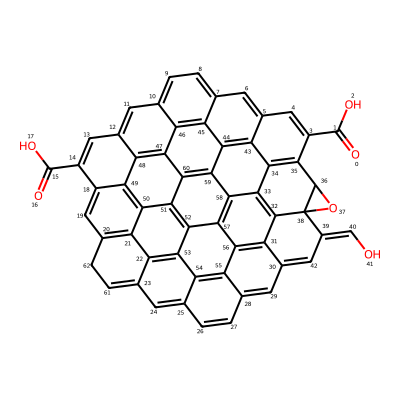

In [171]:
mol = Chem.MolFromSmiles(mol_list[keys[39]])
mol

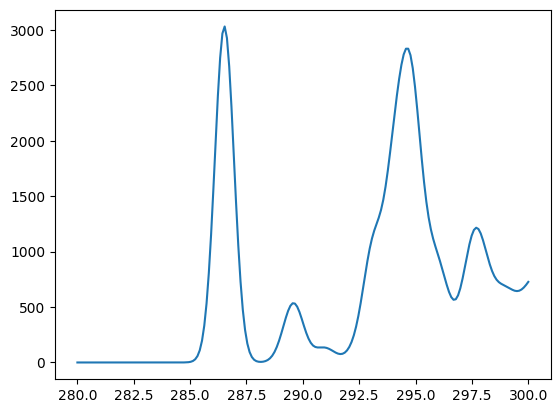

In [178]:
x = np.linspace(280, 300, num=200, endpoint=True)

plt.plot(x, spec_list[keys[39]]['8'])
plt.show()

In [155]:
bad_mols = ['0','2','7','9','10','12','14','15','16','17','18','22','23','27','31','32','33','36',
            '37','38','41','42','43','46','47','48','50','51','52','53','54','55','56','59','61',
            '62','63','65','67','68','71','74','75','76','78','79','81','84','85','88','89','90']

print(len(bad_mols))

52


In [156]:
good_mols = ['1','3','4','5','6','8','11','13','19','20','21','24','25','26','28','29','30','34',
             '35','39','40','44','45','49','57','58','60','64','66','69','70','72','73','77',
             '80','82','83','86','87']

print(len(good_mols))

39


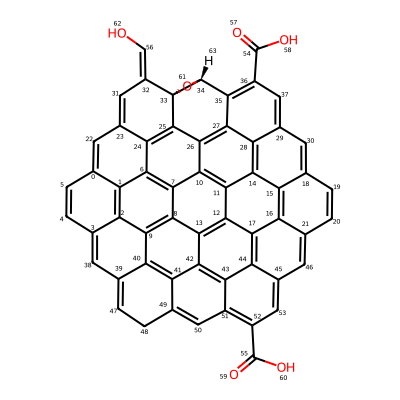

In [10]:
path = '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2/OPT_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2.xyz'

raw_mol = MolFromXYZFile(path)
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol)
mol = copy.deepcopy(conn_mol)
mol = Chem.RemoveAllHs(mol)
mol

In [6]:
# The pattern to identify the optimized .xyz file
pattern = r'OPT_[\w]+\.xyz'

xyz_files = []
# Loop through all the molecule folders and get the optimized .xyz files
for subdir in subdirs:
    files = [f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]

    for filename in files:
        if re.match(pattern, filename):
            xyz_file = filename
            xyz_files.append(xyz_file)
            break

print(xyz_files)

['OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_3_0.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2.xyz', 'OPT_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0.xyz', 'OPT_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_0_1.xyz', 'OPT_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_1.xyz', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2.xyz', 'OPT_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2.xyz', 'OPT_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_1_iOH_1_iEPOXY_2_ieEPOXY_0_0.xyz', 'OPT_R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0

In [7]:
# Run the rearrange_xyz function on all the molecules
for subdir, f in zip(subdirs, xyz_files):
    rearrange_xyz(subdir, f)

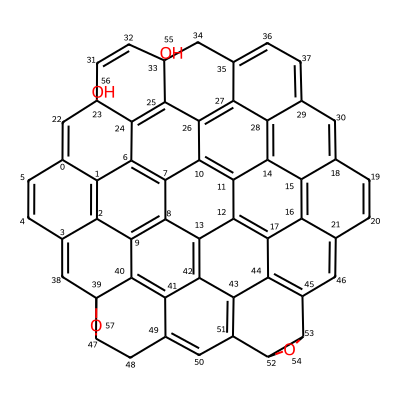

In [8]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.molSize = 400,400

raw_mol = MolFromXYZFile(os.path.join(subdirs[0], xyz_files[0]))
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol)
mol = copy.deepcopy(conn_mol)
mol = Chem.RemoveAllHs(mol)
Chem.RemoveStereochemistry(mol)
mol

In [9]:
smi = Chem.MolToSmiles(mol)
print(smi)

OC12C=CC3(O)Cc4ccc5cc6ccc7cc8c9c%10c(cc%11c%12c%13c%14c%15c(ccc(c%15c%15c1c3c1c4c5c3c6c7c9c4c(c%12%10)c%14c%15c1c34)=C2)=CC%131OC1C%11)C1OC81


In [10]:
Chem.AssignStereochemistry(mol, cleanIt=True, force=True, flagPossibleStereoCenters=True)

t = [[atom.GetIdx(), atom.GetProp('_CIPRank')] for atom in mol.GetAtoms()]

symm_dict = {}

for atom in mol.GetAtoms():
    symm_dict[atom.GetIdx()] = atom.GetProp('_CIPRank')

print(symm_dict)

{0: '46', 1: '44', 2: '45', 3: '47', 4: '10', 5: '9', 6: '30', 7: '36', 8: '39', 9: '31', 10: '38', 11: '42', 12: '43', 13: '41', 14: '40', 15: '35', 16: '34', 17: '37', 18: '24', 19: '6', 20: '5', 21: '22', 22: '13', 23: '52', 24: '20', 25: '19', 26: '29', 27: '26', 28: '32', 29: '23', 30: '8', 31: '12', 32: '11', 33: '51', 34: '1', 35: '16', 36: '2', 37: '4', 38: '14', 39: '53', 40: '21', 41: '25', 42: '33', 43: '27', 44: '28', 45: '18', 46: '7', 47: '50', 48: '0', 49: '15', 50: '3', 51: '17', 52: '48', 53: '49', 54: '56', 55: '54', 56: '55', 57: '57'}


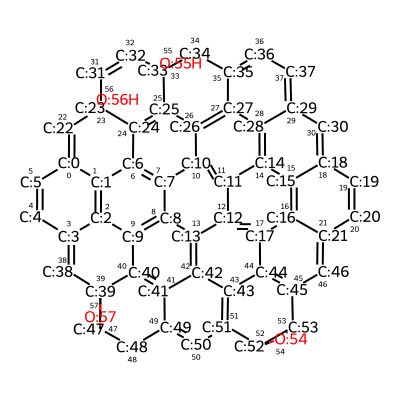

In [11]:
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

mol

In [12]:
loc_dircs = [os.path.join(subdirs[0], d) for d in os.listdir(subdirs[0]) if os.path.isdir(os.path.join(subdirs[0], d))]
print(loc_dircs)

['../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/34', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/37', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/53', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/7', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/56', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/51', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/21', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/24', '../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_

In [13]:
loc_names = [f for f in os.listdir(subdirs[0]) if os.path.isdir(os.path.join(subdirs[0], f))]
print(loc_names)

['34', '37', '53', '7', '56', '51', '21', '24', '27', '43', '6', '46', '41', '11', '49', '19', '14', '17', '33', '5', '36', '31', '39', '55', '50', '23', '4', '26', '29', '45', '40', '48', '13', '16', '32', '35', '30', '38', '54', '57', '52', '22', '25', '20', '9', '28', '44', '47', '42', '12', '15', '10', '8', '18']


In [14]:
name_dirs = [x[1] for x in os.walk(subdirs[0])][0]
print(name_dirs)

['34', '37', '53', '7', '56', '51', '21', '24', '27', '43', '6', '46', '41', '11', '49', '19', '14', '17', '33', '5', '36', '31', '39', '55', '50', '23', '4', '26', '29', '45', '40', '48', '13', '16', '32', '35', '30', '38', '54', '57', '52', '22', '25', '20', '9', '28', '44', '47', '42', '12', '15', '10', '8', '18']


In [18]:
spec_dict = {}
x = np.linspace(280, 300, num=200, endpoint=True)
sigma = 0.6

for i in range(len(loc_dircs)):
    loc_dir = loc_dircs[i]
    
    loc_files = [f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]
    dict_ind = str(int(loc_names[i]))

    for filename in loc_files:
        if filename.endswith('.abs.stk'):
            spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])

            energies = spec_df['Peaks']
            osc = spec_df['Strength']

            gE = broaden_spectrum(energies, osc, x, sigma)
            spec_dict[dict_ind] = gE

        break
    

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_17708/3221205441.py:13: SyntaxWarning: invalid escape sequence '\s'
  spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])


In [19]:
spec_dict

{'37': [6.504432463718675e-61,
  3.58266596066597e-59,
  1.8656607621852218e-57,
  9.1851973692508e-56,
  4.275370598932367e-54,
  1.8814318983423678e-52,
  7.827673592434544e-51,
  3.0789765878494946e-49,
  1.1450107045479087e-47,
  4.0257073144610295e-46,
  1.3381486053966945e-44,
  4.205290533140201e-43,
  1.249445131138996e-41,
  3.5096831595768682e-40,
  9.320692750721457e-39,
  2.3402273510060884e-37,
  5.555172033749755e-36,
  1.2467133415006418e-34,
  2.645241742033958e-33,
  5.306324842091299e-32,
  1.0063569509158174e-30,
  1.8044301455718767e-29,
  3.0588484914620683e-28,
  4.902366790589683e-27,
  7.428201331248114e-26,
  1.0641225855022198e-24,
  1.4412187518096195e-23,
  1.8454340677214978e-22,
  2.2340748060661006e-21,
  2.55698172941992e-20,
  2.766868351870056e-19,
  2.830613553734364e-18,
  2.737815541667478e-17,
  2.5035695243986873e-16,
  2.164449260217093e-15,
  1.769163315712833e-14,
  1.3671676323979297e-13,
  9.988714380391242e-13,
  6.8997312703075474e-12,
  4.

In [15]:
loc_files = [f for f in os.listdir('../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/34') if os.path.isfile(os.path.join('../GNN_XAS_Node/raw_data/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2/34', f))]

print(loc_files)

['R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2_34.inp', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2.out.abs.stk', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2.out.abs.dat', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2.xyz', 'slurm-7206984.out', 'OPT_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2.xyz', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_2_2_34.sh']


In [17]:
dict_ind = str(int(loc_names[0]))
print(dict_ind)

34
